# Graded Assignment 2 - Air Quality and Weather in the Netherlands


# Introduction to This Template Notebook

* This is a **group** notebook.
* Make sure you work in a **copy** of `...-template.ipynb`,
**renamed** to `...-yourIDnrs.ipynb`,
where `yourIDnrs` is the TU/e identification numbers of the members of the group.

<div class="alert alert-danger" role="danger">
<h3>Integrity</h3>
<ul>
    <li>In this course you must act according to the rules of the TU/e code of scientific conduct.</li>
    <li>This exercise or graded assignment is to be executed by the members of the group independently from other people.</li>
    <li>You must not copy from the Internet, your friends, books... If you represent other people's work as your own, then that constitutes fraud and will be reported to the Examination Committee.</li>
    <li>Making your work available to others (complicity) also constitutes fraud.</li>
</ul>
</div>

You are expected to work with Python code and Markdown in this notebook.

Proceed in this notebook as follows:
* **Read** the assignment (separate PDF).
* **Write** your decisions/solutions/interpretations in the appropriate sections.
  * For this you can use both Code and Markdown cells. Information about how to use these cells is available in the _Getting Started_ assignment.
* **Run** _all_ code cells (also the ones _without_ your code),
    _in linear order_ from the first code cell.

**Personalize your notebook**:
1. Copy the following line of code:

  ```python
  AUTHOR_ID_NRS = ['1234567', '2234567', '3234567', '4234567']
  ```
1. Paste them between the marker lines in the next code cell.
1. Fill in the _identification numbers_ of all members of the group as a list of strings between the `Author` markers.
1. Run the code cell by putting the cursor there and typing **Control-Enter**.


In [1]:
#// BEGIN_TODO [Author] Name, Id.nr., Date, as strings (1 point)





#// END_TODO [Author]

## Table of Contents

- [Preparation](#Preparation)
    - [Load the libraries](#Load-the-libraries)
- [Part 1a. Hypothesis selection](#Part-1a:-Hypothesis-selection)
- [Part 1b. Hypothesis refinement](#Part-1b:-Hypothesis-refinement)
- [Part 2. Queries and data cleaning](#Part-2:-Queries-and-data-cleaning)
- [Part 3. Hypothesis testing and interpretation](#Part-3.-Hypothesis-testing-and-interpretation)
- [Part 4. Pitching results](#Part-4.-Pitching-results)

## Preparation
### Load the libraries

In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression         # for linear regression
from sklearn.cluster import KMeans                        # for clustering
from sklearn.tree import DecisionTreeClassifier           # for decision tree mining
from sklearn.metrics import mean_absolute_error, confusion_matrix
from sklearn.model_selection import train_test_split
from treeviz import tree_print                            # to print decision tree

import scipy.stats as stats                               # to compute z-scores
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import sqlite3                                            # to interact with the database
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib inline                                 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns                                     # also improves the look of plots
sns.set()
plt.rcParams['figure.figsize'] = 10, 5                    # default hor./vert. size of plots, in inches
plt.rcParams['lines.markeredgewidth'] = 1                 # to fix issue with seaborn box plots; needed after import seaborn

## Part 1a: Hypothesis selection

In [3]:
# Use this cell as you like, and add more cells as needed.

## Part 1b: Hypothesis refinement

In [4]:
# Use this cell as you like, and add more cells as needed.

## Part 2: Queries and data cleaning

In [5]:
# Reading in data
#personalization
aq_station_code_1 = 'NL10444'
aq_station_code_2 = 'NL10538'
aq_station_code_3 = 'NL10133'
aq_station_code_4 = 'NL10738'
compound1 = 'nh_3'
compound2 = 'no_2'
compound3 = 'o_3'

Info on the first station:

In [6]:
# Path to the database
db_path = 'datasets/aqw.db'

# Connect to database
cnx = sqlite3.connect(db_path)

QUERY_WEATHER_STATION_1 = f"""
    SELECT aq_station_code, weather_station_code, distance 
    FROM close_stations 
    WHERE aq_station_code='{aq_station_code_1}'
    GROUP BY aq_station_code
"""

# Get the closest weather station info
closest_weather_info = pd.read_sql_query(QUERY_WEATHER_STATION_1, cnx).squeeze()

# Extract weather code from the SQL result
weather_station_code = int(closest_weather_info['weather_station_code'])

# Extract weather station distance from the SQL result
aq_weather_distance = closest_weather_info['distance']

QUERY_AQ = f"""
    SELECT datetime, {', '.join((compound1, compound2, compound3))} 
    FROM air_quality_data 
    WHERE station_code='{aq_station_code_1}'
"""

# Get compound1 and compound2 info of the air quality station
df_aq = pd.read_sql_query(QUERY_AQ, cnx, 
                          index_col='datetime', 
                          parse_dates=['datetime'])

WEATHER_FACTORS = ['wind_direction', 'wind_speed', 'wind_gust']

QUERY_WEATHER = f"""
    SELECT datetime, {', '.join(WEATHER_FACTORS)} 
    FROM weather_data 
    WHERE station_code={weather_station_code}
"""

# Get weather data of the closest weather station
df_weather = pd.read_sql_query(QUERY_WEATHER, cnx, 
                               index_col='datetime', 
                               parse_dates=['datetime'])


df_station1 = df_aq.join(df_weather, how='outer')
df_station1['station_code'] = aq_station_code_1
df_station1['year'] = df_station1.index.year
df_station1['month'] = df_station1.index.month
df_station1['day_of_year'] = df_station1.index.dayofyear
df_station1['week'] = df_station1['day_of_year'] // 7 + 1
df_station1['hour'] = df_station1.index.hour

df_station1.tail()

,nh_3,no_2,o_3,wind_direction,wind_speed,wind_gust,station_code,year,month,day_of_year,week,hour
datetime,,,,,,,,,,,,
2021-12-31 19:00:00+01:00,0.501,10.89,43.11,240,7.0,12.0,NL10444,2021,12,365,53,19
2021-12-31 20:00:00+01:00,NaN,9.33,45.90,240,7.0,11.0,NL10444,2021,12,365,53,20
2021-12-31 21:00:00+01:00,0.402,12.86,42.66,240,7.0,13.0,NL10444,2021,12,365,53,21
2021-12-31 22:00:00+01:00,0.553,10.46,45.63,230,6.0,11.0,NL10444,2021,12,365,53,22
2021-12-31 23:00:00+01:00,0.588,11.29,45.89,210,5.0,9.0,NL10444,2021,12,365,53,23


On the second station

In [7]:
QUERY_WEATHER_STATION_2 = f"""
    SELECT aq_station_code, weather_station_code, distance 
    FROM close_stations 
    WHERE aq_station_code='{aq_station_code_2}'
    GROUP BY aq_station_code
"""

# Get the closest weather station info
closest_weather_info = pd.read_sql_query(QUERY_WEATHER_STATION_2, cnx).squeeze()

# Extract weather code from the SQL result
weather_station_code = int(closest_weather_info['weather_station_code'])

# Extract weather station distance from the SQL result
aq_weather_distance = closest_weather_info['distance']

QUERY_AQ = f"""
    SELECT datetime, {', '.join((compound1, compound2, compound3))} 
    FROM air_quality_data 
    WHERE station_code='{aq_station_code_2}'
"""

# Get compound1 and compound2 info of the air quality station
df_aq = pd.read_sql_query(QUERY_AQ, cnx, 
                          index_col='datetime', 
                          parse_dates=['datetime'])

WEATHER_FACTORS = ['wind_direction', 'wind_speed', 'wind_gust']

QUERY_WEATHER = f"""
    SELECT datetime, {', '.join(WEATHER_FACTORS)} 
    FROM weather_data 
    WHERE station_code={weather_station_code}
"""

# Get weather data of the closest weather station
df_weather = pd.read_sql_query(QUERY_WEATHER, cnx, 
                               index_col='datetime', 
                               parse_dates=['datetime'])


df_station2 = df_aq.join(df_weather, how='outer')
df_station2['station_code'] = aq_station_code_2
df_station2['year'] = df_station2.index.year
df_station2['month'] = df_station2.index.month
df_station2['day_of_year'] = df_station2.index.dayofyear
df_station2['week'] = df_station2['day_of_year'] // 7 + 1
df_station2['hour'] = df_station2.index.hour

df_station2.tail()

,nh_3,no_2,o_3,wind_direction,wind_speed,wind_gust,station_code,year,month,day_of_year,week,hour
datetime,,,,,,,,,,,,
2021-12-31 19:00:00+01:00,1.579,42.10,36.92,240,8.0,11.0,NL10538,2021,12,365,53,19
2021-12-31 20:00:00+01:00,1.485,16.45,41.32,240,6.0,11.0,NL10538,2021,12,365,53,20
2021-12-31 21:00:00+01:00,1.555,11.83,41.97,230,7.0,9.0,NL10538,2021,12,365,53,21
2021-12-31 22:00:00+01:00,1.597,9.71,45.71,230,6.0,10.0,NL10538,2021,12,365,53,22
2021-12-31 23:00:00+01:00,1.339,10.49,42.13,230,6.0,9.0,NL10538,2021,12,365,53,23


The third station:

In [8]:
QUERY_WEATHER_STATION_3 = f"""
    SELECT aq_station_code, weather_station_code, distance 
    FROM close_stations 
    WHERE aq_station_code='{aq_station_code_3}'
    GROUP BY aq_station_code
"""

# Get the closest weather station info
closest_weather_info = pd.read_sql_query(QUERY_WEATHER_STATION_3, cnx).squeeze()

# Extract weather code from the SQL result
weather_station_code = int(closest_weather_info['weather_station_code'])

# Extract weather station distance from the SQL result
aq_weather_distance = closest_weather_info['distance']

QUERY_AQ = f"""
    SELECT datetime, {', '.join((compound1, compound2, compound3))} 
    FROM air_quality_data 
    WHERE station_code='{aq_station_code_3}'
"""

# Get compound1 and compound2 info of the air quality station
df_aq = pd.read_sql_query(QUERY_AQ, cnx, 
                          index_col='datetime', 
                          parse_dates=['datetime'])

WEATHER_FACTORS = ['wind_direction', 'wind_speed', 'wind_gust']

QUERY_WEATHER = f"""
    SELECT datetime, {', '.join(WEATHER_FACTORS)} 
    FROM weather_data 
    WHERE station_code={weather_station_code}
"""

# Get weather data of the closest weather station
df_weather = pd.read_sql_query(QUERY_WEATHER, cnx, 
                               index_col='datetime', 
                               parse_dates=['datetime'])


df_station3 = df_aq.join(df_weather, how='outer')
df_station3['station_code'] = aq_station_code_3
df_station3['year'] = df_station3.index.year
df_station3['month'] = df_station3.index.month
df_station3['day_of_year'] = df_station3.index.dayofyear
df_station3['week'] = df_station3['day_of_year'] // 7 + 1
df_station3['hour'] = df_station3.index.hour

df_station3.tail()

,nh_3,no_2,o_3,wind_direction,wind_speed,wind_gust,station_code,year,month,day_of_year,week,hour
datetime,,,,,,,,,,,,
2021-12-31 19:00:00+01:00,None,6.63,42.86,240,5.0,9.0,NL10133,2021,12,365,53,19
2021-12-31 20:00:00+01:00,None,6.11,41.61,240,4.0,8.0,NL10133,2021,12,365,53,20
2021-12-31 21:00:00+01:00,None,5.50,42.92,250,3.0,7.0,NL10133,2021,12,365,53,21
2021-12-31 22:00:00+01:00,None,4.84,44.80,230,3.0,6.0,NL10133,2021,12,365,53,22
2021-12-31 23:00:00+01:00,None,6.20,43.35,220,4.0,5.0,NL10133,2021,12,365,53,23


The forth station of the observation dont forget to close

In [9]:
QUERY_WEATHER_STATION_4 = f"""
    SELECT aq_station_code, weather_station_code, distance 
    FROM close_stations 
    WHERE aq_station_code='{aq_station_code_4}'
    GROUP BY aq_station_code
"""

# Get the closest weather station info
closest_weather_info = pd.read_sql_query(QUERY_WEATHER_STATION_4, cnx).squeeze()

# Extract weather code from the SQL result
weather_station_code = int(closest_weather_info['weather_station_code'])

# Extract weather station distance from the SQL result
aq_weather_distance = closest_weather_info['distance']

QUERY_AQ = f"""
    SELECT datetime, {', '.join((compound1, compound2, compound3))} 
    FROM air_quality_data 
    WHERE station_code='{aq_station_code_4}'
"""

# Get compound1 and compound2 info of the air quality station
df_aq = pd.read_sql_query(QUERY_AQ, cnx,
                         index_col='datetime', 
                         parse_dates=['datetime'])

WEATHER_FACTORS = ['wind_direction', 'wind_speed', 'wind_gust']

QUERY_WEATHER = f"""
    SELECT datetime, {', '.join(WEATHER_FACTORS)} 
    FROM weather_data 
    WHERE station_code={weather_station_code}
"""

# Get weather data of the closest weather station
df_weather = pd.read_sql_query(QUERY_WEATHER, cnx,
                              index_col='datetime', 
                              parse_dates=['datetime'])



df_station4 = df_aq.join(df_weather, how='outer')
df_station4['station_code'] = aq_station_code_4
df_station4['year'] = df_station4.index.year
df_station4['month'] = df_station4.index.month
df_station4['day_of_year'] = df_station4.index.dayofyear
df_station4['week'] = df_station4['day_of_year'] // 7 + 1
df_station4['hour'] = df_station4.index.hour

df_station4.head()

,nh_3,no_2,o_3,wind_direction,wind_speed,wind_gust,station_code,year,month,day_of_year,week,hour
datetime,,,,,,,,,,,,
2012-01-01 00:00:00+01:00,NaN,NaN,NaN,230.0,5.0,8.0,NL10738,2012,1,1,1,0
2012-01-01 01:00:00+01:00,NaN,14.24,30.81,230.0,6.0,8.0,NL10738,2012,1,1,1,1
2012-01-01 02:00:00+01:00,NaN,12.09,33.26,230.0,6.0,9.0,NL10738,2012,1,1,1,2
2012-01-01 03:00:00+01:00,NaN,8.01,41.22,230.0,5.0,9.0,NL10738,2012,1,1,1,3
2012-01-01 04:00:00+01:00,NaN,6.95,44.49,220.0,6.0,10.0,NL10738,2012,1,1,1,4


In [10]:
df_data= df_station1.append(df_station2)
df_data.append(df_station3)
df_data.append(df_station4)
df_data

C:\Users\quanb\AppData\Local\Temp\ipykernel_23904\2337552438.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data= df_station1.append(df_station2)
C:\Users\quanb\AppData\Local\Temp\ipykernel_23904\2337552438.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data.append(df_station3)
C:\Users\quanb\AppData\Local\Temp\ipykernel_23904\2337552438.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data.append(df_station4)


,nh_3,no_2,o_3,wind_direction,wind_speed,wind_gust,station_code,year,month,day_of_year,week,hour
datetime,,,,,,,,,,,,
2012-01-01 00:00:00+01:00,NaN,NaN,NaN,220,7.0,9.0,NL10444,2012,1,1,1,0
2012-01-01 01:00:00+01:00,NaN,20.03,34.41,230,7.0,10.0,NL10444,2012,1,1,1,1
2012-01-01 02:00:00+01:00,NaN,10.88,44.65,230,8.0,10.0,NL10444,2012,1,1,1,2
2012-01-01 03:00:00+01:00,NaN,6.41,50.53,240,9.0,13.0,NL10444,2012,1,1,1,3
2012-01-01 04:00:00+01:00,NaN,6.96,51.39,240,9.0,13.0,NL10444,2012,1,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00+01:00,1.579,42.10,36.92,240,8.0,11.0,NL10538,2021,12,365,53,19
2021-12-31 20:00:00+01:00,1.485,16.45,41.32,240,6.0,11.0,NL10538,2021,12,365,53,20
2021-12-31 21:00:00+01:00,1.555,11.83,41.97,230,7.0,9.0,NL10538,2021,12,365,53,21


In [15]:
df_station1_temp = df_station1.groupby(['year', 'day_of_year']).mean()
# df_station1_temp = df_station1_temp.loc[2017:2017]

df_station2_temp = df_station2.groupby(['year', 'day_of_year']).mean()
# df_station2_temp = df_station2_temp.loc[2017:2017]

df_station3_temp = df_station3.groupby(['year', 'day_of_year']).mean()
# df_station3_temp = df_station3_temp.loc[2017:2017]

df_station4_temp = df_station4.groupby(['year', 'day_of_year']).mean()
# df_station4_temp = df_station4_temp.loc[2017:2017]

df_station1_temp


C:\Users\quanb\AppData\Local\Temp\ipykernel_23904\3990139605.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_station1_temp = df_station1.groupby(['year', 'day_of_year']).mean()
C:\Users\quanb\AppData\Local\Temp\ipykernel_23904\3990139605.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_station2_temp = df_station2.groupby(['year', 'day_of_year']).mean()
C:\Users\quanb\AppData\Local\Temp\ipykernel_23904\3990139605.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or se

nh_3       no_2        o_3  wind_direction  wind_speed  \
year day_of_year                                                               
2012 1            0.503158  10.188261  46.899130      225.416667    7.875000   
     2            0.334167   6.162917  57.352500      239.166667    6.458333   
     3            0.392083  11.015833  54.144167      220.833333   12.416667   
     4            0.418500   5.087083  63.065833      258.333333   12.125000   
     5            0.383333   2.763333  65.514583      292.916667   13.625000   
...                    ...        ...        ...             ...         ...   
2021 361          3.430125  23.210417   5.257500      130.416667    4.083333   
     362          1.760042   9.235000  51.702609      214.583333    6.916667   
     363          1.078545  15.997500  30.440417      229.583333    5.708333   
     364          0.385000  10.824167  46.755833      231.250000   10.083333   
     365          1.114217  10.658333  42.698750      227.916667    8.625000   

                  wind_gust  month  week  hour  
year day_of_year                                
2012 1            11.916667    1.0   1.0  11.5  
     2            10.125000    1.0   1.0  11.5  
     3            18.458333    1.0   1.0  11.5  
     4            18.125000    1.0   1.0  11.5  
     5            21.625000    1.0   1.0  11.5  
...                     ...    ...   ...   ...  
2021 361           6.125000   12.0  52.0  11.5  
     362          10.791667   12.0  52.0  11.5  
     363           9.041667   12.0  52.0  11.5  
     364          15.333333   12.0  53.0  11.5  
     365          13.666667   12.0  53.0  11.5  

[3653 rows x 9 columns]

Generating four heatmaps ***(Nitrogen Dioxide And Wind Speed)*** for each air quality station.

Text(0.5, 0.98, 'Relationship Between Nitrogen Dioxide And Wind Speeds At 4 Different Air Quality Station')

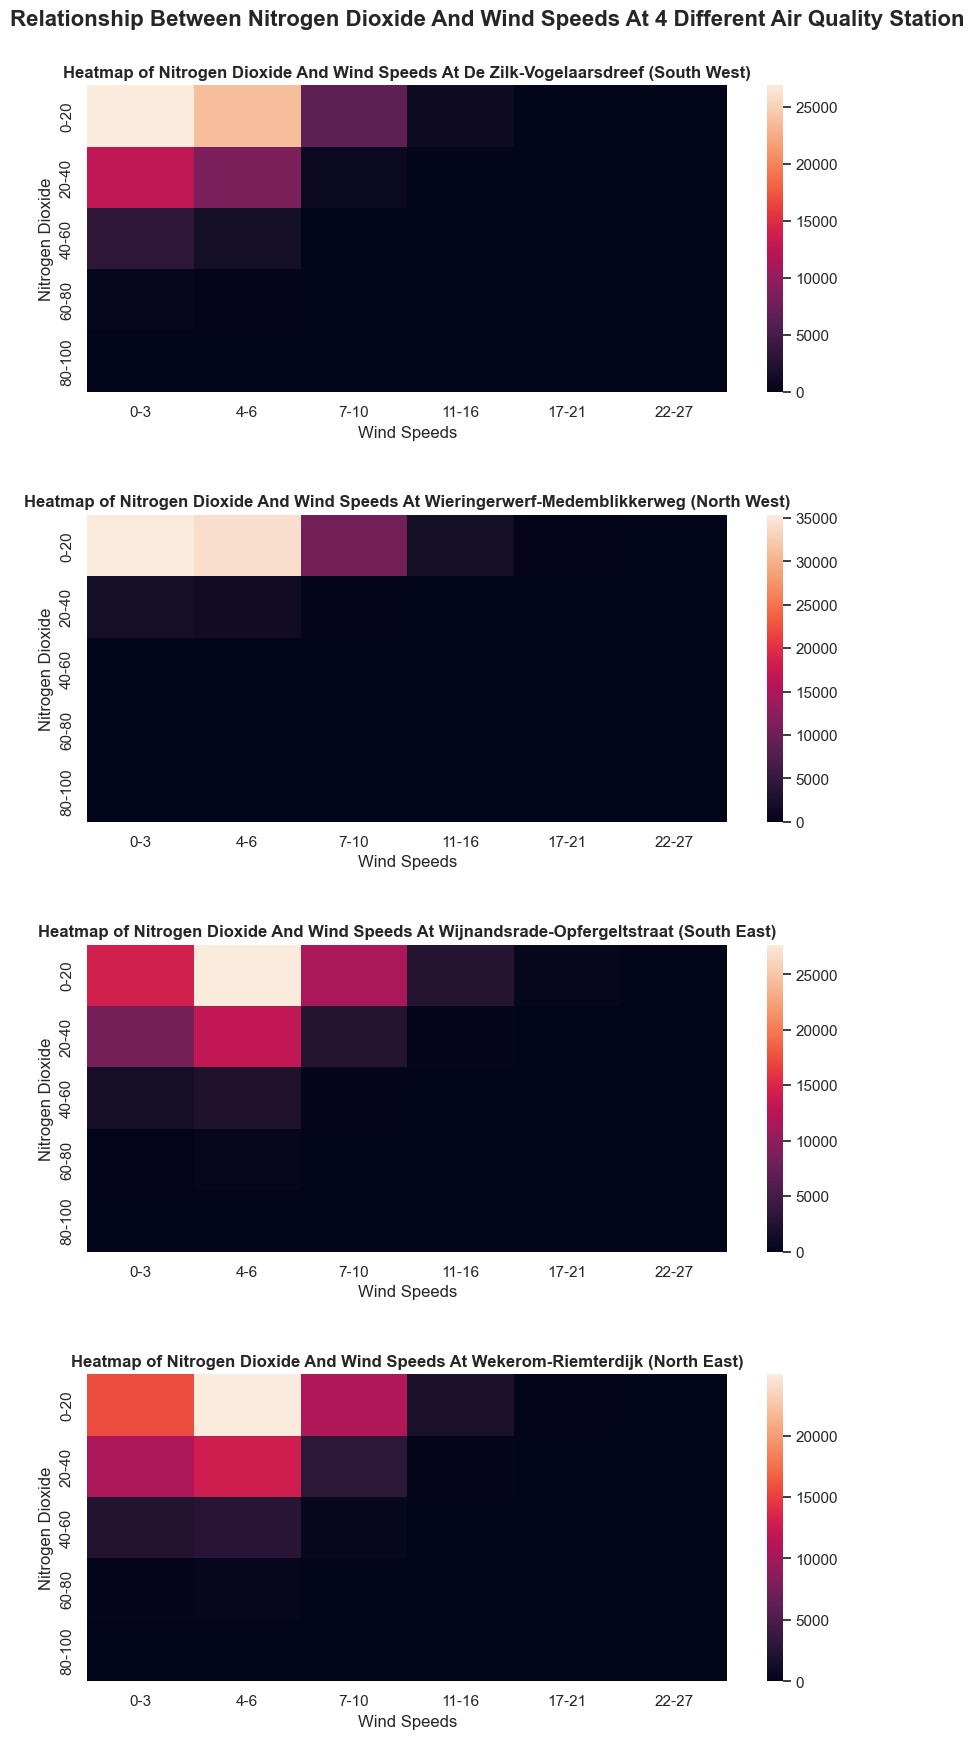

In [49]:
# HEATMAPS OF NO2 AND WIND SPEEDS AT 4 DIFFERENT AIR QUALITY STATIONS

fig, ax =plt.subplots(nrows = 4, ncols=1, figsize=(10,19))

# wind_speed 0 -> 20
# nh_3 0 -> 30

#aq_station_code_1 = 'NL10444'
#aq_station_code_2 = 'NL10538'
#aq_station_code_3 = 'NL10133'
#aq_station_code_4 = 'NL10738'


wind_speed_levels = ['0-3','4-6','7-10', '11-16','17-21','22-27']
no_levels = ['0-20','20-40','40-60','60-80','80-100']

# Dividing the compound and wind into bins based on their values 
df_station1['no_2_levels'] = pd.cut(df_station1['no_2'], len(no_levels), labels = no_levels)
df_station1['wind_speed_levels'] = pd.cut(df_station1['wind_speed'], len(wind_speed_levels), labels = wind_speed_levels)

df_station2['no_2_levels'] = pd.cut(df_station2['no_2'], len(no_levels), labels = no_levels)
df_station2['wind_speed_levels'] = pd.cut(df_station2['wind_speed'], len(wind_speed_levels), labels = wind_speed_levels)

df_station3['no_2_levels'] = pd.cut(df_station3['no_2'], len(no_levels), labels = no_levels)
df_station3['wind_speed_levels'] = pd.cut(df_station3['wind_speed'], len(wind_speed_levels), labels = wind_speed_levels)

df_station4['no_2_levels'] = pd.cut(df_station4['no_2'], len(no_levels), labels = no_levels)
df_station4['wind_speed_levels'] = pd.cut(df_station4['wind_speed'], len(wind_speed_levels), labels = wind_speed_levels)

# Grouping based on bins and count the occurences of the desired compound
df_station1_no_2_data = df_station1.groupby(['no_2_levels','wind_speed_levels'])['no_2'].count()
df_station2_no_2_data = df_station2.groupby(['no_2_levels','wind_speed_levels'])['no_2'].count()
df_station3_no_2_data = df_station3.groupby(['no_2_levels','wind_speed_levels'])['no_2'].count()
df_station4_no_2_data = df_station4.groupby(['no_2_levels','wind_speed_levels'])['no_2'].count()

# Transform Data into Matrix Shape
df_station1_no_2_matrix = df_station1_no_2_data.unstack()
df_station2_no_2_matrix = df_station2_no_2_data.unstack()
df_station3_no_2_matrix = df_station3_no_2_data.unstack()
df_station4_no_2_matrix = df_station4_no_2_data.unstack()

# Plot the heatmaps
sns.heatmap(data = df_station1_no_2_matrix, ax = ax[0])
sns.heatmap(data = df_station2_no_2_matrix, ax = ax[1])
sns.heatmap(data = df_station3_no_2_matrix, ax = ax[2])
sns.heatmap(data = df_station4_no_2_matrix, ax = ax[3])

# Setting Titles, X-Labels, Y-Labels
ax[0].set_title('Heatmap of Nitrogen Dioxide And Wind Speeds At De Zilk-Vogelaarsdreef (South West)', weight = 'bold')
ax[0].set_xlabel('Wind Speeds')
ax[0].set_ylabel('Nitrogen Dioxide')

ax[1].set_title('Heatmap of Nitrogen Dioxide And Wind Speeds At Wieringerwerf-Medemblikkerweg (North West)', weight = 'bold')
ax[1].set_xlabel('Wind Speeds')
ax[1].set_ylabel('Nitrogen Dioxide')

ax[2].set_title('Heatmap of Nitrogen Dioxide And Wind Speeds At Wijnandsrade-Opfergeltstraat (South East)', weight = 'bold')
ax[2].set_xlabel('Wind Speeds')
ax[2].set_ylabel('Nitrogen Dioxide')

ax[3].set_title('Heatmap of Nitrogen Dioxide And Wind Speeds At Wekerom-Riemterdijk (North East)', weight = 'bold')
ax[3].set_xlabel('Wind Speeds')
ax[3].set_ylabel('Nitrogen Dioxide')

# Styling the graphs
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.94, 
                    wspace=0.3, 
                    hspace=0.4)

plt.suptitle("Relationship Between Nitrogen Dioxide And Wind Speeds At 4 Different Air Quality Station", weight = 'bold', size = 16)


Generating four scatterplots ***(Nitrogen Dioxide And Wind Gust)*** for each air quality station.

Text(0.5, 0.98, 'Relationship Between Nitrogen Dioxide And Wind Speeds At 4 Different Air Quality Station')

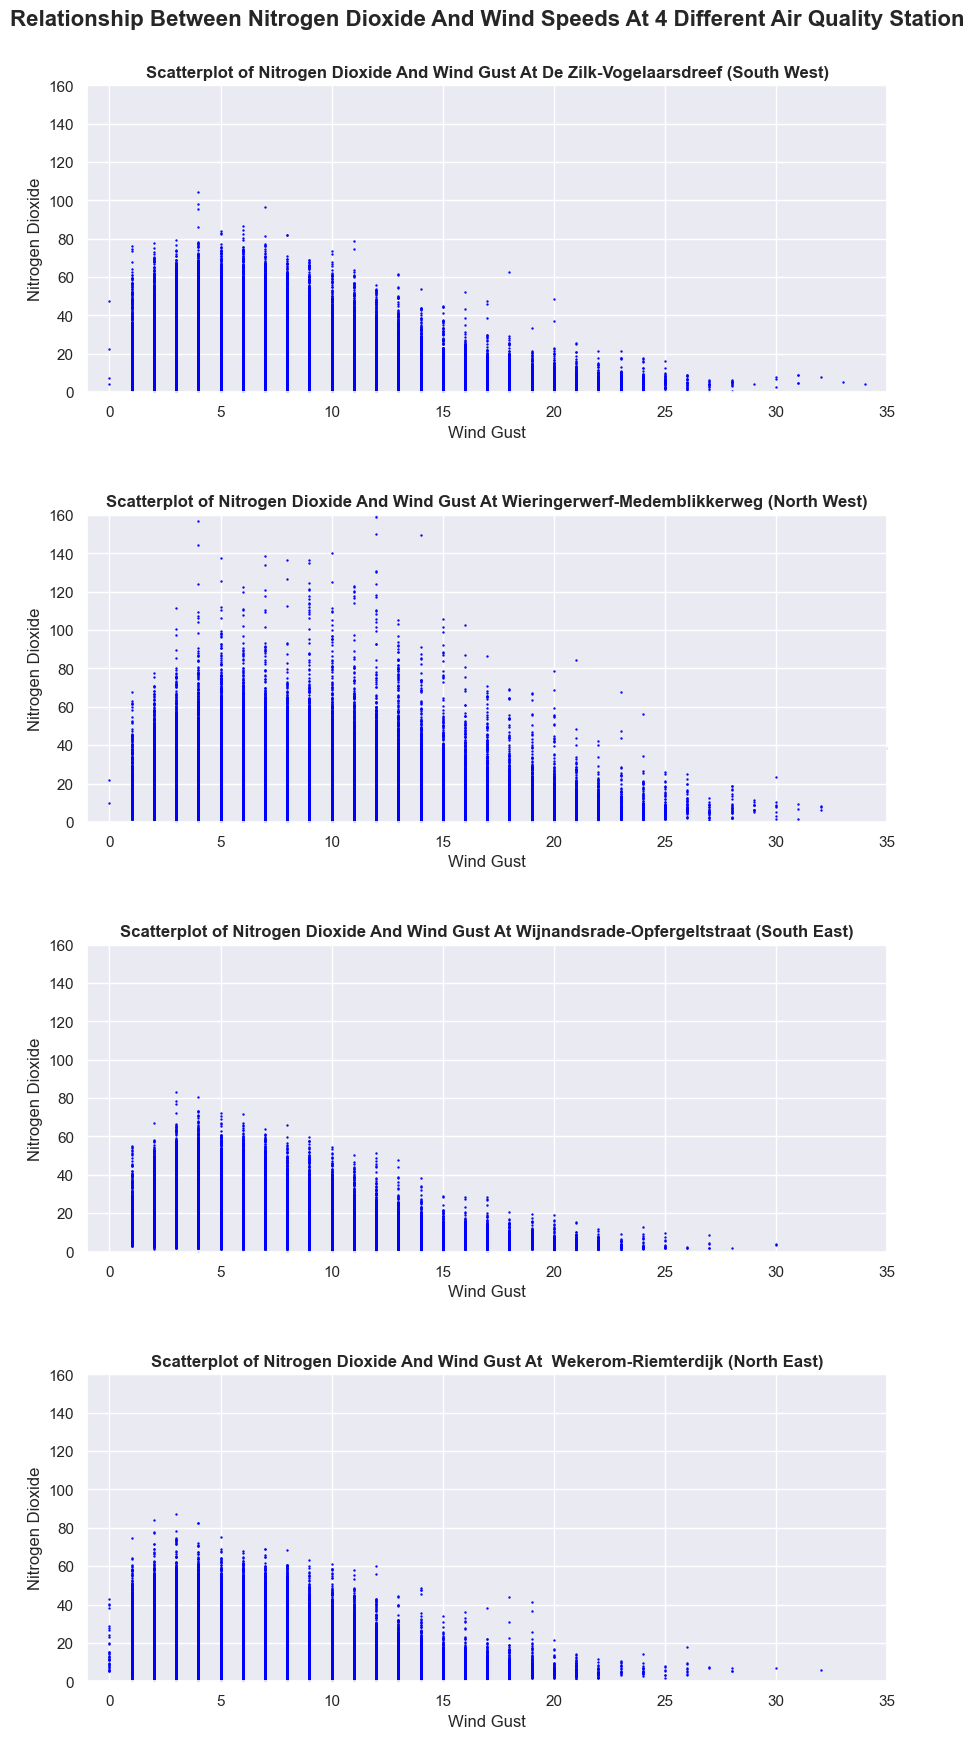

In [74]:
# SCATTERPLOTS OF NO2 AND WIND GUSTS AT 4 AIR QUALITY STATIONS
fig, ax =plt.subplots(nrows = 4, ncols=1, figsize=(10,19))

# Making the Scatterplots
df_station1.plot(kind = 'scatter', x = 'wind_gust', y = 'no_2',color = 'blue', s = 0.5, ax = ax[0])
df_station2.plot(kind = 'scatter', x = 'wind_gust', y = 'no_2',color = 'blue', s = 0.5, ax = ax[1])
df_station3.plot(kind = 'scatter', x = 'wind_gust', y = 'no_2',color = 'blue', s = 0.5, ax = ax[2])
df_station4.plot(kind = 'scatter', x = 'wind_gust', y = 'no_2',color = 'blue', s = 0.5, ax = ax[3])

# Labelling stuff
ax[0].set_xlim(-1, 35)
ax[0].set_ylim(0,160)
ax[0].set_xlabel('Wind Gust')
ax[0].set_ylabel('Nitrogen Dioxide')
ax[0].set_title('Scatterplot of Nitrogen Dioxide And Wind Gust At De Zilk-Vogelaarsdreef (South West)', weight = 'bold')

ax[1].set_xlim(-1, 35)
ax[1].set_ylim(0,160)
ax[1].set_xlabel('Wind Gust')
ax[1].set_ylabel('Nitrogen Dioxide')
ax[1].set_title('Scatterplot of Nitrogen Dioxide And Wind Gust At Wieringerwerf-Medemblikkerweg (North West)', weight = 'bold')

ax[2].set_xlim(-1, 35)
ax[2].set_ylim(0,160)
ax[2].set_xlabel('Wind Gust')
ax[2].set_ylabel('Nitrogen Dioxide')
ax[2].set_title('Scatterplot of Nitrogen Dioxide And Wind Gust At Wijnandsrade-Opfergeltstraat (South East)', weight = 'bold')

ax[3].set_xlim(-1, 35)
ax[3].set_ylim(0,160)
ax[3].set_xlabel('Wind Gust')
ax[3].set_ylabel('Nitrogen Dioxide')
ax[3].set_title('Scatterplot of Nitrogen Dioxide And Wind Gust At  Wekerom-Riemterdijk (North East)', weight = 'bold')


# Styling the graphs
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.94, 
                    wspace=0.3, 
                    hspace=0.4)

plt.suptitle("Relationship Between Nitrogen Dioxide And Wind Speeds At 4 Different Air Quality Station", weight = 'bold', size = 16)

In [ ]:
#close the database when finished
cnx.close()

In [ ]:
df_data

Line graph with the concentrations on Y-axis and Time on X-axis superimposed the four choosen place.

## Part 3. Hypothesis testing and interpretation

In [ ]:
# Use this cell as you like, and add more cells as needed.

## Part 4. Polishing and pitching results

In [ ]:
# This section is only for generating figures if you need it. You may leave it empty.

# Feedback

Please fill in this questionaire to help us improve this course for the next year. Your feedback will be anonymized and will not affect your grade in any way!

### How many hours did you spend on these exercises?

Assign a number to `feedback_time`.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_1] (0 point)

#// END_FEEDBACK [Feedback_1] (0 point)

import numbers

assert isinstance(feedback_time, numbers.Number), "Please assign a number to feedback_time"
print(feedback_time)

### How difficult did you find these exercises?

Assign an integer to `feedback_difficulty`, on a scale 0 - 10, with 0 being very easy, 5 being just right, and 10 being very difficult.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_2] (0 point)

#// END_FEEDBACK [Feedback_2] (0 point)

import numbers

assert isinstance(feedback_difficulty, numbers.Number), "Please assign a number to feedback_difficulty"
print(feedback_difficulty)

### (Optional) What did you like?

Assign a string to `feedback_like`.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_3] (0 point)

#// END_FEEDBACK [Feedback_3] (0 point)

### (Optional) What can be improved?

Assign a string to `feedback_improve`. Please be specific, so that we can act on your feedback. For example, mention the specific exercises and what was unclear.

In [ ]:
#// BEGIN_FEEDBACK [Feedback_4] (0 point)

#// END_FEEDBACK [Feedback_4] (0 point)




## How to Submit Your Work

1. **Before submitting**, you must run your notebook by doing **Kernel > Restart & Run All**.  
   Make sure that your notebook runs without errors **in linear order**.
1. Remember to rename the notebook as explained at the beginning of this notebook.
1. Submit the executed notebook with your work
   for the appropriate assignment in **Canvas**.
1. In the **Momotor** tab in Canvas,
  you can select that assignment again to find some feedback on your submitted work.
  If there are any problems reported by _Momotor_,
  then you need to fix those,
  and **resubmit the fixed notebook**.

In case of a high workload on our server
(because many students submit close to the deadline),
it may take longer to receive the feedback.




---

In [ ]:
# List all defined names
%whos

---

# (End of Notebook) <span class="tocSkip"></span>

&copy; 2017-2023 - **TU/e** - Eindhoven University of Technology